# Draft Day 2021

Thurs Sept 2, 2021

[nbviewer link](https://nbviewer.jupyter.org/github/joeeoj/fantasy-football/blob/main/draft_day_results.ipynb)

In [1]:
from pathlib import Path

import altair as alt
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
DATA_DIR = Path.cwd() / 'data'

# http://mkweb.bcgsc.ca/colorblind/palettes.mhtml
DOMAIN = ['Fully  Maccinated', 'Federal Way Yu', 'Draftin Herbert First Pick', 'Spenny Willy',
          'Too Many Cooks', "Rippin' Swigs", 'Herb Your Enthusiasm', 'Elite starts  with Eli',
          'Seattle Fantasy Team', 'Team barrett', 'Scooty Lewis and the News', 'Raiders Are Good']
RANGE = ['#9F0162', '#009F81', '#FF5AAF', '#00FCCF', '#8400CD', '#008DF9',
          '#00C2F9', '#FFB2FD', '#A40122', '#E20134', '#FF6E3A', '#FFC33B']

In [3]:
drafts = pd.read_csv(DATA_DIR / 'draft_data_2021.csv').sort_values('bid_amount', ascending=False)
espn = pd.read_csv(DATA_DIR / 'espn_draft_trends_2021.csv')  # draft trends from ESPN

df = pd.merge(drafts, espn, on='player_id')
assert len(df) == len(drafts)

### leftover draft money

<img src="https://media.giphy.com/media/ND6xkVPaj8tHO/giphy.gif"/>

In [4]:
bids = df.groupby('team_name')['bid_amount'].sum().reset_index()
bids['remaining'] = 200 - bids['bid_amount']
bids['pct_remaining'] = bids['remaining'] / 200
bids = bids.sort_values('remaining', ascending=False).drop('bid_amount', axis=1)

bids.style.format({'remaining': '${:.0f}', 'pct_remaining': '{:.0%}'})

,team_name,remaining,pct_remaining
11,Too Many Cooks,$14,7%
5,Raiders Are Good,$10,5%
6,Rippin' Swigs,$8,4%
2,Federal Way Yu,$3,2%
4,Herb Your Enthusiasm,$3,2%
0,Draftin Herbert First Pick,$2,1%
3,Fully Maccinated,$1,0%
7,Scooty Lewis and the News,$1,0%
1,Elite starts with Eli,$0,0%
8,Seattle Fantasy Team,$0,0%


In [5]:
df['team_name'].unique()

array(['Fully  Maccinated', 'Federal Way Yu',
       'Draftin Herbert First Pick', 'Spenny Willy', 'Too Many Cooks',
       "Rippin' Swigs", 'Herb Your Enthusiasm', 'Elite starts  with Eli',
       'Seattle Fantasy Team', 'Team barrett',
       'Scooty Lewis and the News', 'Raiders Are Good'], dtype=object)

### breakdown of nominating teams winning their bid?

In [6]:
(pd.DataFrame(((df['team_name'] == df['nominating_team_name']).value_counts() / len(drafts)))
.rename({0: 'nominating_team_won_bid'}, axis=1)
.style.format('{:.0%}'))

,nominating_team_won_bid
False,77%
True,23%


## League spending versus ESPN data

From [ESPN Live Draft Trends](https://fantasy.espn.com/football/livedraftresults)

`ppr_auc_value` - ESPN recommended value for PPR league

In [7]:
cols = ['team_name', 'nominating_team_name', 'player_name', 'pos', 'ppr_auc_value', 'avg_auc_value',
        'bid_amount', 'avg_draft_pos', 'overall_pick']

prices = df[cols].copy()

# filter out $1 and $2 bids
# prices = prices[prices['bid_amount'] > 2]

# actual bid price minus ESPN recommended price
prices['actual_vs_rec_diff'] = prices['bid_amount'] - prices['ppr_auc_value']

# actual bid price minus average draft prices
prices['actual_vs_avg_diff'] = prices['bid_amount'] - prices['avg_auc_value']

### Summed differences by team and position

`actual_vs_rec_diff` - Actual price minus ESPN recommendation

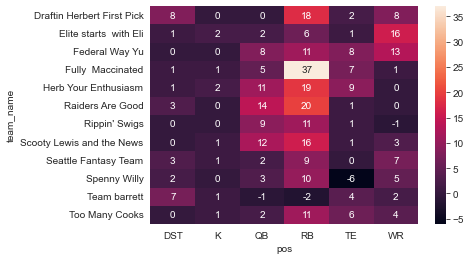

In [8]:
rec_pivot = pd.pivot_table(prices, index='team_name', columns='pos', values='actual_vs_rec_diff', aggfunc='sum').fillna(0).astype(int)

sns.heatmap(rec_pivot, annot=True);

`actual_vs_avg_diff` - actual bid minus avg price

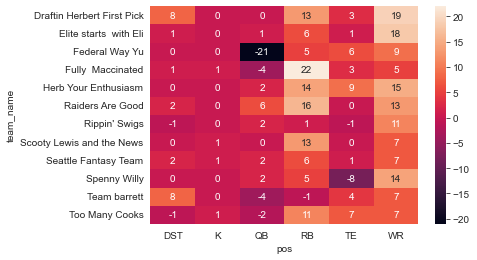

In [9]:
avg_pivot = pd.pivot_table(prices, index='team_name', columns='pos', values='actual_vs_avg_diff', aggfunc='sum').fillna(0).astype(int)

sns.heatmap(avg_pivot, annot=True);

## Per player breakdown

The line is a linear regression across all drafted players

In [10]:
chart = (alt.Chart(prices)
            .mark_point()
            .encode(x='ppr_auc_value', y='bid_amount', color=alt.Color('pos:N'), tooltip=['pos', 'player_name', 'team_name', 'nominating_team_name',
                                                                                          'bid_amount', 'ppr_auc_value', 'actual_vs_rec_diff'])
            .properties(width=400, height=400, title='Bid amount vs ESPN recommended PPR value'))

(chart + chart.transform_regression('ppr_auc_value', 'bid_amount').mark_line()).interactive()

alt.LayerChart(...)

here we trended closer to the average

In [11]:
chart = (alt.Chart(prices)
            .mark_point()
            .encode(x='avg_auc_value', y='bid_amount', color='pos:N', tooltip=['pos', 'player_name', 'team_name', 'nominating_team_name',
                                                                             'bid_amount', 'avg_auc_value', 'actual_vs_avg_diff'])
            .properties(width=400, height=400, title='Bid amount vs ESPN average PPR bid'))

(chart + chart.transform_regression('avg_auc_value', 'bid_amount').mark_line()).interactive()

alt.LayerChart(...)

### Diff between bid amount and ESPN recommendation by team and player

Only showing diffs more than $2

In [12]:
(alt.Chart(prices)
    .mark_bar()
    .encode(x='actual_vs_rec_diff:Q', y=alt.Y('player_name:N', sort='-x'),
            color=alt.Color('team_name', scale=alt.Scale(domain=DOMAIN, range=RANGE)),
            tooltip=['team_name', 'pos', 'player_name', 'bid_amount', 'ppr_auc_value', 'actual_vs_rec_diff'])
    .properties(height=600, title='Price diff with ESPN PPR projections')
    .transform_filter(
        (abs(alt.datum.actual_vs_rec_diff) > 2)
    ))

alt.Chart(...)

### Diff between bid amount and ESPN averages by team and player

In [13]:
(alt.Chart(prices)
    .mark_bar()
    .encode(x='actual_vs_avg_diff:Q', y=alt.Y('player_name:N', sort='-x'),
            color=alt.Color('team_name', scale=alt.Scale(domain=DOMAIN, range=RANGE)),
            tooltip=['team_name', 'pos', 'player_name', 'bid_amount', 'avg_auc_value', 'actual_vs_avg_diff'])
    .properties(height=600, title='Price diff with avg ESPN PPR bid amounts')
    .transform_filter(
        (abs(alt.datum.actual_vs_rec_diff) > 2)
    ))

alt.Chart(...)